In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.\
    appName("DMF").\
    getOrCreate()

In [2]:
df1=spark.read.csv('/DMF/DMF/ssdm1')
df2=spark.read.csv('/DMF/DMF/ssdm2')
df3=spark.read.csv('/DMF/DMF/ssdm3')
df=df1.union(df2).union(df3)

In [3]:
df.show(10)

+--------------------+
|                 _c0|
+--------------------+
| 001010001MUZZEY ...|
| 001010009SMITH  ...|
| 001010010HAMMOND...|
| 001010011DREW   ...|
| 001010012CATE   ...|
| 001010013WHORFE ...|
| 001010015AMOS   ...|
| 001010016KUNCHO ...|
| 001010017MICHALS...|
| 001010019BODWELL...|
+--------------------+
only showing top 10 rows



In [4]:
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf, to_date
import re

udf1 = udf(lambda x:x[0:1].strip(),StringType())
udf2 = udf(lambda x:x[1:10].strip(),StringType())
udf3 = udf(lambda x:x[10:30].strip(),StringType())
udf4 = udf(lambda x:x[30:34].strip(),StringType())
udf5 = udf(lambda x:x[34:49].strip(),StringType())
udf6 = udf(lambda x:x[49:64].strip(),StringType())
udf7 = udf(lambda x:x[64:65].strip(),StringType())
udf8 = udf(lambda x:re.sub("00(\d{4})",r'01\1',x[65:73].strip()),StringType())
udf9 = udf(lambda x:x[73:81].strip(),StringType())

df=df.withColumn('transaction_type',udf1('_c0'))\
    .withColumn('security_number',udf2('_c0'))\
    .withColumn('last_name',udf3('_c0'))\
    .withColumn('name_suffix',udf4('_c0'))\
    .withColumn('first_name',udf5('_c0'))\
    .withColumn('middle_name',udf6('_c0'))\
    .withColumn('V/P',udf7('_c0'))\
    .withColumn('death_date',to_date(udf8('_c0'),'MMddyyyy'))\
    .withColumn('birth_date',to_date(udf9('_c0'),'MMddyyyy'))\
    .drop('_c0')

In [5]:
df.limit(10).toPandas()

,transaction_type,security_number,last_name,name_suffix,first_name,middle_name,V/P,death_date,birth_date
0,,001010001,MUZZEY,,GRACE,,,1975-12-01,1902-04-16
1,,001010009,SMITH,,ROGER,,,1969-04-01,1892-02-04
2,,001010010,HAMMOND,,KENNETH,,,1976-03-01,1904-04-24
3,,001010011,DREW,,LEON,R,V,1987-08-30,1908-06-14
4,,001010012,CATE,,OLIVE,,,1981-09-01,1908-09-21
5,,001010013,WHORFE,,FRANK,,,1962-09-01,1888-04-06
6,,001010015,AMOS,,CHESTER,,,1984-02-01,1910-02-16
7,,001010016,KUNCHO,,DIMITRI,,,1981-03-01,1910-06-04
8,,001010017,MICHALS,,WILLIAM,,,1970-12-01,1907-11-07
9,,001010019,BODWELL,,MINNIE,,,1984-03-01,1895-04-05


In [6]:
df=df.drop('transaction_type').withColumnRenamed("V/P","VP")

In [7]:
df.summary().show()

+-------+-------------------+---------+-----------+--------------------+------------------+--------+
|summary|    security_number|last_name|name_suffix|          first_name|       middle_name|      VP|
+-------+-------------------+---------+-----------+--------------------+------------------+--------+
|  count|           87735016| 87735016|   87735016|            87735016|          87735016|87735016|
|   mean|3.245460570182641E8|     null|       null| 2.765166666666667E8| 1.915335463258786|    null|
| stddev|1.675738885478578E8|     null|       null|2.9333901984094167E8|1.8540821037063988|    null|
|    min|          001010001|         |           |                    |                  |        |
|    25%|       1.96124748E8|     null|       null|                21.0|               0.0|    null|
|    50%|       3.35384325E8|     null|       null|        2.45359261E8|               2.0|    null|
|    75%|       4.61226328E8|     null|       null|        5.84190718E8|               3.0|

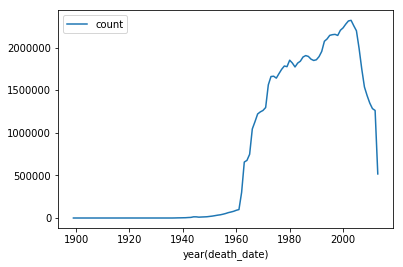

In [31]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import year
df.groupBy(year(df.death_date)).count().orderBy('year(death_date)').toPandas().plot(x='year(death_date)',y='count')

In [32]:
num_animals = 12
label_chinese='Обезьяна','Коза','Лошадь','Змея','Дракон','Кролик','Тигр','Бык','Крыса','Свинья','Собака','Петух'

In [10]:
df = df.withColumn('chinese_year_birth', year(df.birth_date)%num_animals)
df = df.withColumn('chinese_year_death', year(df.death_date)%num_animals)
df = df.withColumn('age', year(df.death_date)-year(df.birth_date))

In [11]:
df.limit(10).toPandas()

,security_number,last_name,name_suffix,first_name,middle_name,VP,death_date,birth_date,chinese_year_birth,chinese_year_death,age
0,001010001,MUZZEY,,GRACE,,,1975-12-01,1902-04-16,6,7,73
1,001010009,SMITH,,ROGER,,,1969-04-01,1892-02-04,8,1,77
2,001010010,HAMMOND,,KENNETH,,,1976-03-01,1904-04-24,8,8,72
3,001010011,DREW,,LEON,R,V,1987-08-30,1908-06-14,0,7,79
4,001010012,CATE,,OLIVE,,,1981-09-01,1908-09-21,0,1,73
5,001010013,WHORFE,,FRANK,,,1962-09-01,1888-04-06,4,6,74
6,001010015,AMOS,,CHESTER,,,1984-02-01,1910-02-16,2,4,74
7,001010016,KUNCHO,,DIMITRI,,,1981-03-01,1910-06-04,2,1,71
8,001010017,MICHALS,,WILLIAM,,,1970-12-01,1907-11-07,11,2,63
9,001010019,BODWELL,,MINNIE,,,1984-03-01,1895-04-05,11,4,89


In [12]:
print(df.where(df.chinese_year_birth > (num_animals - 1)).count())
print(df.where(df.chinese_year_death > (num_animals - 1)).count())

0
0


In [13]:
colors = ['#ffbcd9','#afdafc','#f400a1','#800080','#893f45','#ff8e0d','#0a4500','#007cad','#6699cc','#ffff99','#423189','#9db1cc']

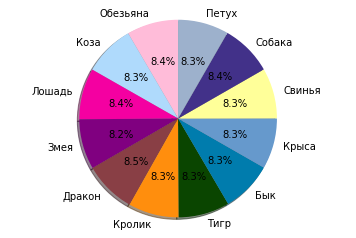

In [33]:
fig1, ax1 = plt.subplots()
sizes=df.groupBy(df.chinese_year_birth)\
    .count()\
    .orderBy('chinese_year_birth')\
    .toPandas()['count']
ax1.pie(sizes[1:], labels=label_chinese, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

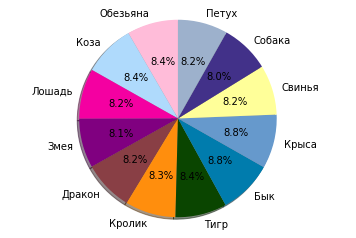

In [34]:
fig1, ax1 = plt.subplots()
sizes=df.groupBy(df.chinese_year_death)\
    .count()\
    .orderBy('chinese_year_death')\
    .toPandas()['count']
ax1.pie(sizes[1:], labels=label_chinese, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [35]:
df.createOrReplaceTempView("DMF")

In [36]:
def build_graphic(chinese_year, title):
    tmp = spark.sql("SELECT range, count(*) as num FROM (SELECT CASE \
        WHEN age BETWEEN 0 AND 9 THEN '0-9' \
        WHEN age BETWEEN 10 AND 19 THEN '10-19'\
        WHEN age BETWEEN 20 AND 29 THEN '20-29' \
        WHEN age BETWEEN 30 AND 39 THEN '30-39'\
        WHEN age BETWEEN 40 AND 49 THEN '40-49' \
        WHEN age BETWEEN 50 AND 59 THEN '50-59'\
        WHEN age BETWEEN 60 AND 69 THEN '60-69' \
        WHEN age BETWEEN 70 AND 79 THEN '70-79'\
        WHEN age BETWEEN 80 AND 89 THEN '80-89' \
        WHEN age BETWEEN 90 AND 99 THEN '90-99'\
        ELSE '>100' \
        END AS range FROM DMF WHERE chinese_year_birth == " + str(chinese_year) + ")\
    GROUP BY range\
    ORDER BY range\
    ").toPandas()\
    .plot.bar(x='range',y='num', figsize=(15,10))
    
    totals = []

    # find the values and append to list
    for i in tmp.patches:
        totals.append(i.get_height())

    # set individual bar lables using above list
    total = sum(totals)

    # set individual bar lables using above list
    for i in tmp.patches:
        tmp.text(i.get_x(), i.get_height()+0.05, str(i.get_height()), fontsize=10, color='dimgrey')
    
    
    tmp.get_legend().remove()
    tmp.set_title(title)
    tmp.set_ylabel('count')

In [ ]:
# for i in range(num_animals):
#     build_graphic(i, label_chinese[i])

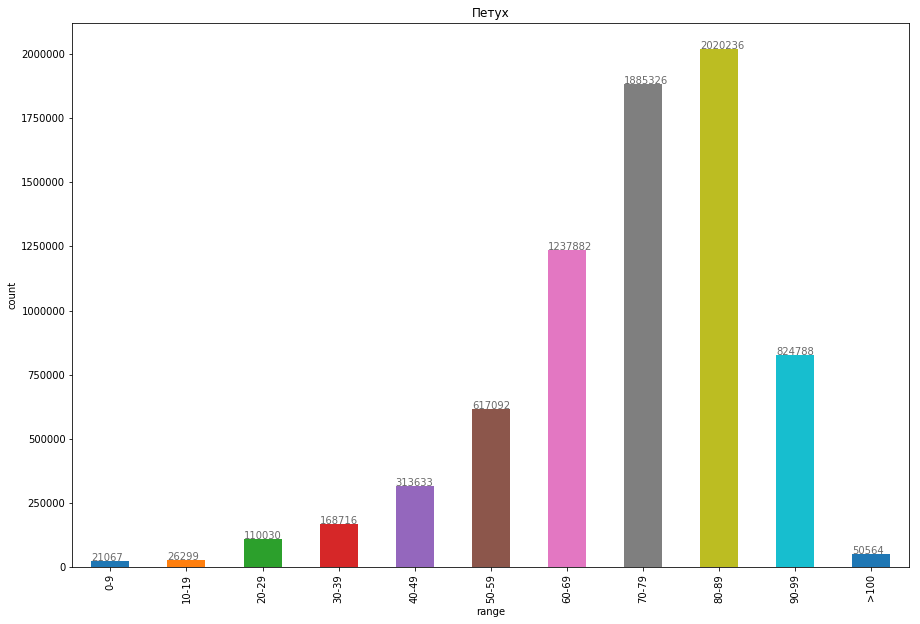

In [38]:
build_graphic(11, label_chinese[11])

In [39]:
def build_graphic_animals(chinese_year, title):
    tmp = spark.sql("SELECT chinese_year_birth, count(*) as num_animals FROM DMF \
    WHERE chinese_year_death == " + str(chinese_year) + " AND chinese_year_birth IS NOT NULL\
    GROUP BY chinese_year_birth\
    ORDER BY chinese_year_birth\
    ").toPandas()\
    .plot.bar(x='chinese_year_birth',y='num_animals', figsize=(15,10))
    
    totals = []

    # find the values and append to list
    for i in tmp.patches:
        totals.append(i.get_height())

    # set individual bar lables using above list
    total = sum(totals)

    # set individual bar lables using above list
    for i in tmp.patches:
        tmp.text(i.get_x(), i.get_height()+0.05, str(i.get_height()), fontsize=10, color='dimgrey')
    
    tmp.get_legend().remove()
    tmp.set_xticklabels(label_chinese)
    tmp.set_title(title)
    tmp.set_ylabel('count')

In [40]:
#for i in range(num_animals):
#    build_graphic_animals(i, label_chinese[i])

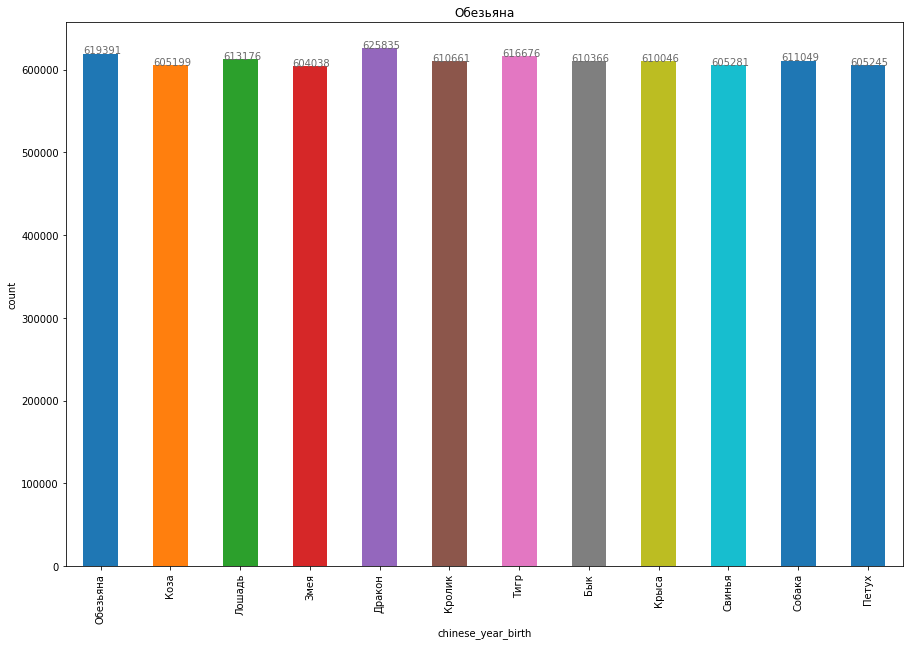

In [41]:
i=0
build_graphic_animals(i, label_chinese[i])

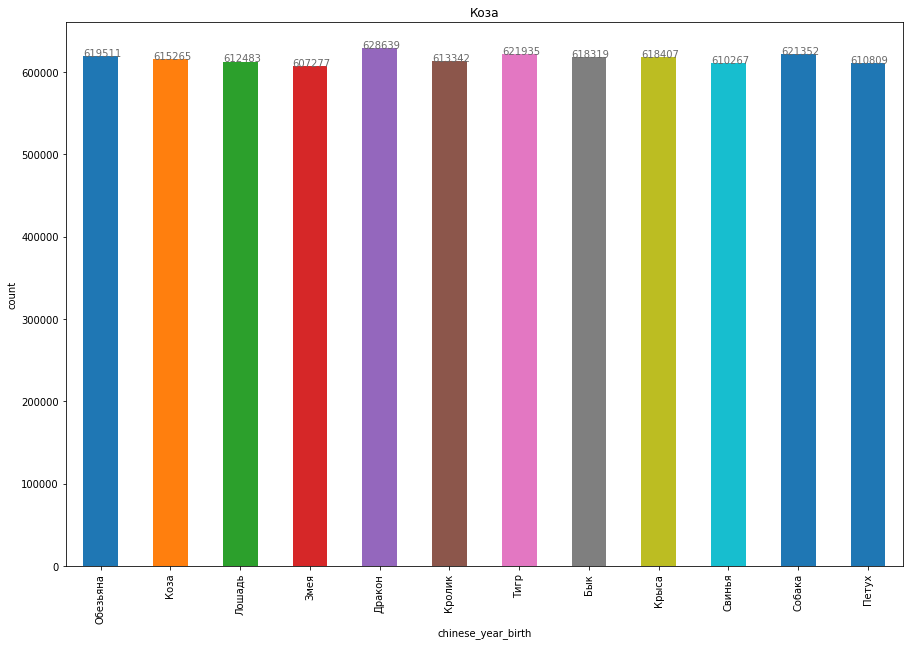

In [42]:
i=1
build_graphic_animals(i, label_chinese[i])

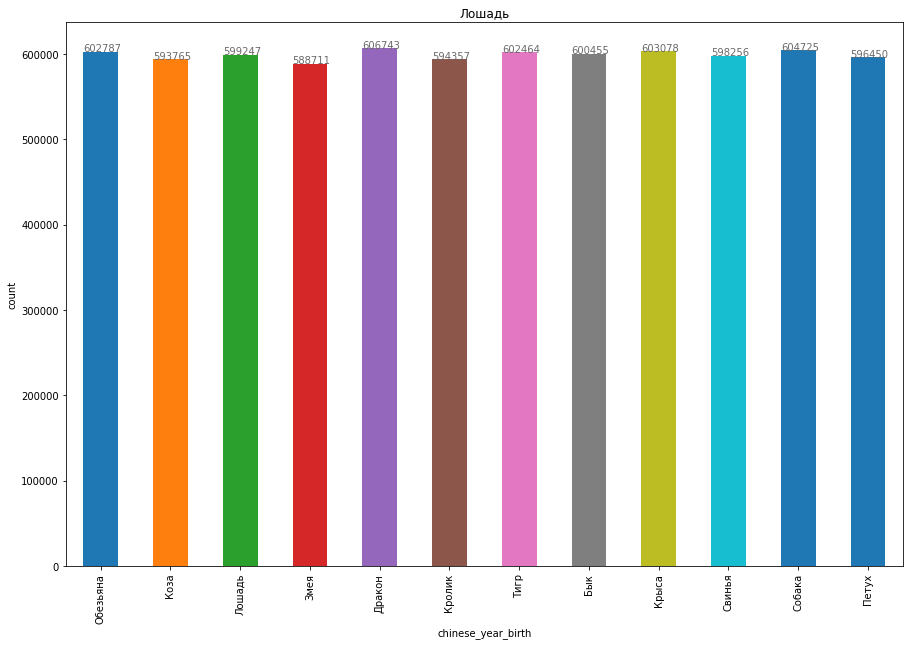

In [43]:
i=2
build_graphic_animals(i, label_chinese[i])

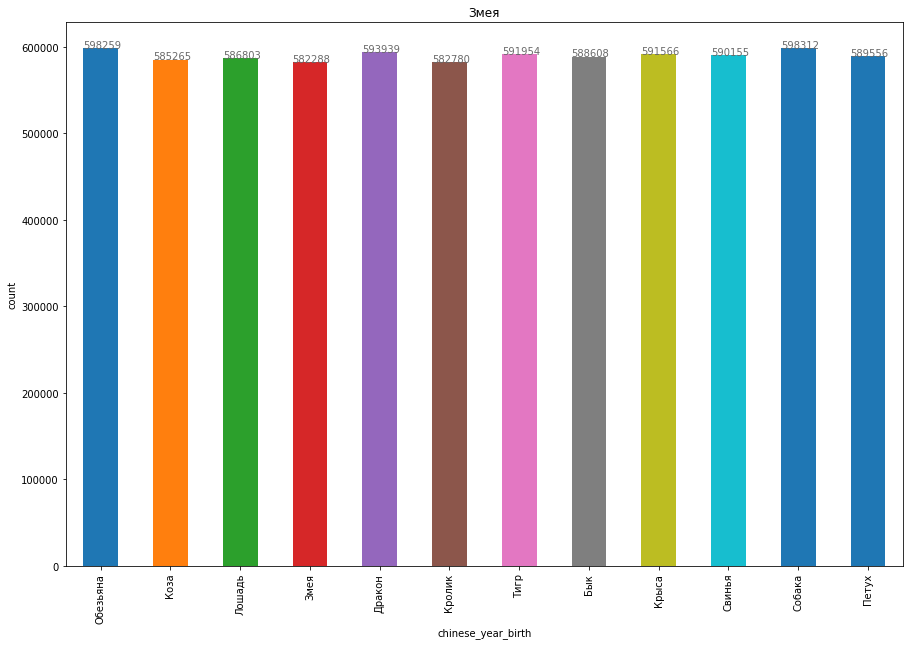

In [44]:
i=3
build_graphic_animals(i, label_chinese[i])

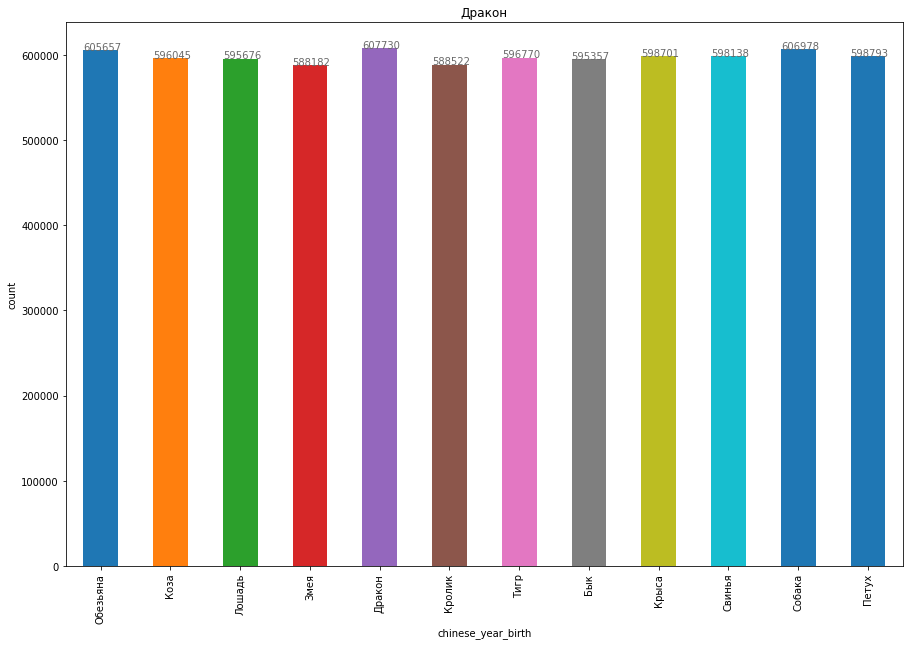

In [45]:
i=4
build_graphic_animals(i, label_chinese[i])

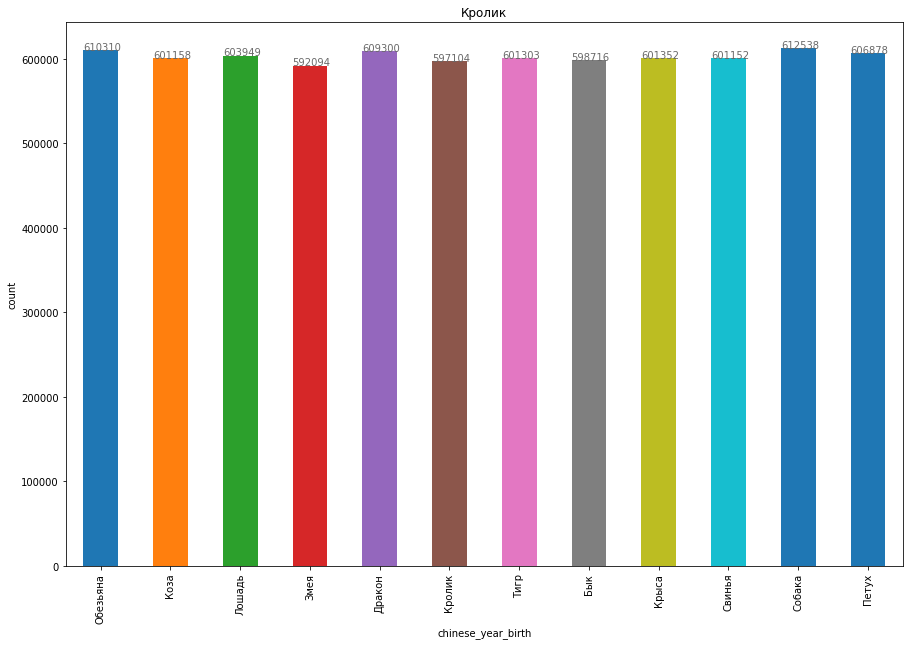

In [46]:
i=5
build_graphic_animals(i, label_chinese[i])

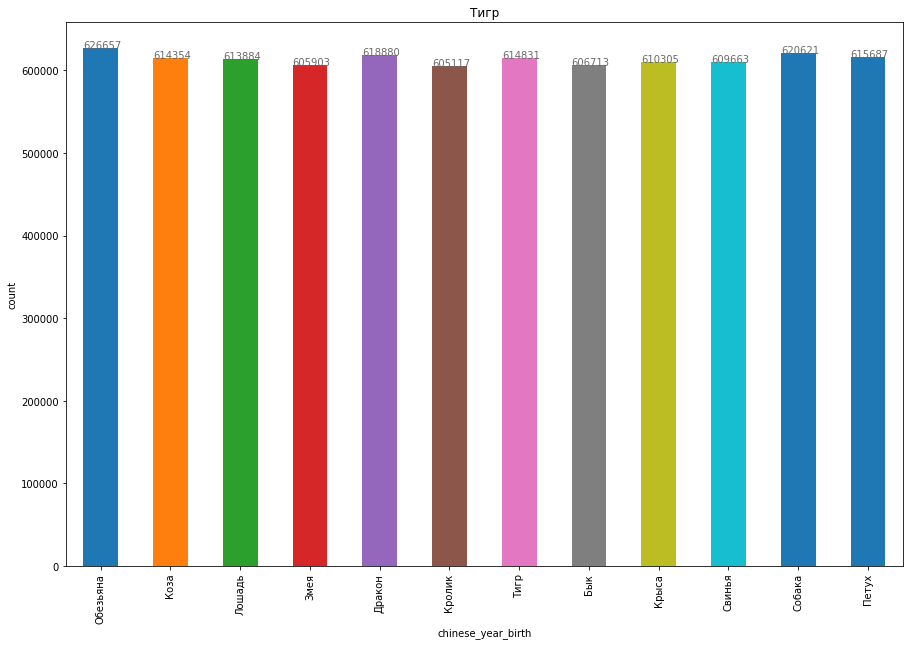

In [47]:
i=6
build_graphic_animals(i, label_chinese[i])

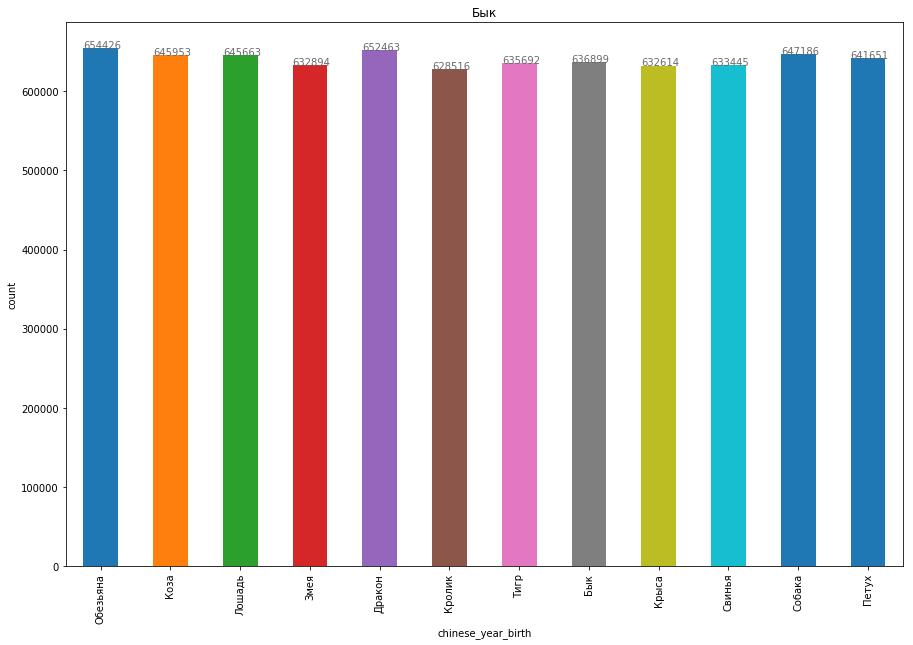

In [48]:
i=7
build_graphic_animals(i, label_chinese[i])

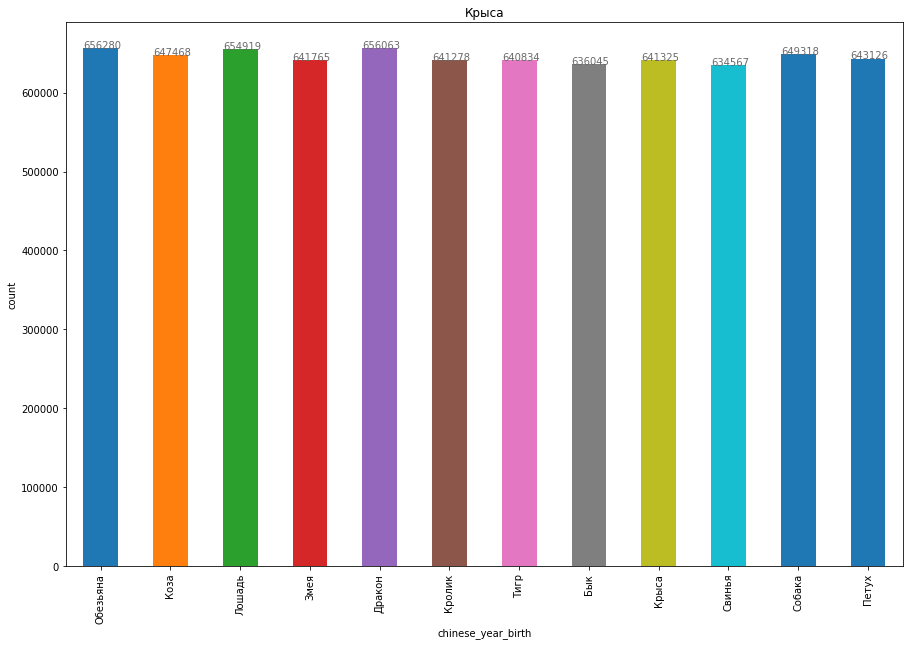

In [49]:
i=8
build_graphic_animals(i, label_chinese[i])

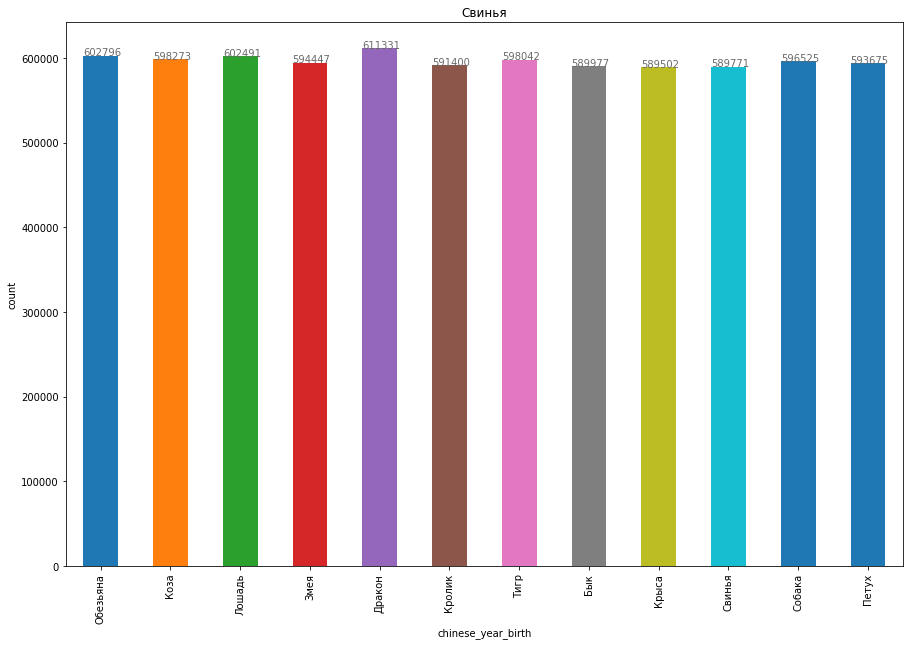

In [50]:
i=9
build_graphic_animals(i, label_chinese[i])

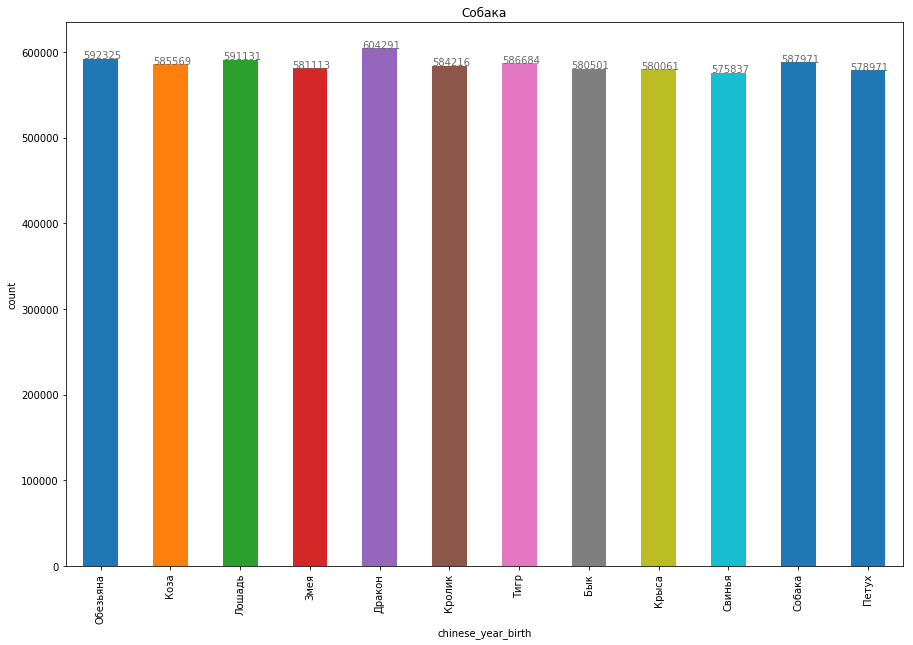

In [51]:
i=10
build_graphic_animals(i, label_chinese[i])

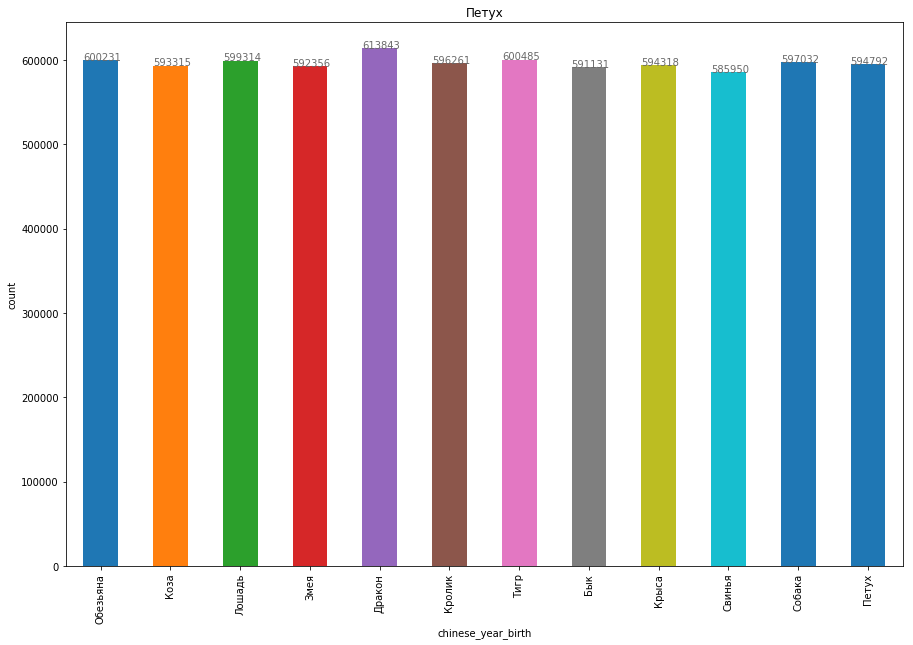

In [52]:
i=11
build_graphic_animals(i, label_chinese[i])

In [56]:
def build_graphic_date(start, end):
    tmp = spark.sql("SELECT chinese_year_birth, count(*) as num_animals FROM DMF \
    WHERE year(death_date) >= " + str(start) + " AND year(death_date) < " + str(end) + " AND chinese_year_birth IS NOT NULL\
    GROUP BY chinese_year_birth\
    ORDER BY chinese_year_birth\
    ").toPandas()\
    .plot.bar(x='chinese_year_birth',y='num_animals', figsize=(15,10))
    
    totals = []

    # find the values and append to list
    for i in tmp.patches:
        totals.append(i.get_height())

    # set individual bar lables using above list
    total = sum(totals)

    # set individual bar lables using above list
    for i in tmp.patches:
        tmp.text(i.get_x(), i.get_height()+0.05, str(i.get_height()), fontsize=10, color='dimgrey')
    
    tmp.get_legend().remove()
    tmp.set_xticklabels(label_chinese)
    tmp.set_title(str(start) + " - " + str(end))
    tmp.set_ylabel('count')

In [57]:
#for i in range(1900, 2000, 10):
#    build_graphic_date(i, i+10)

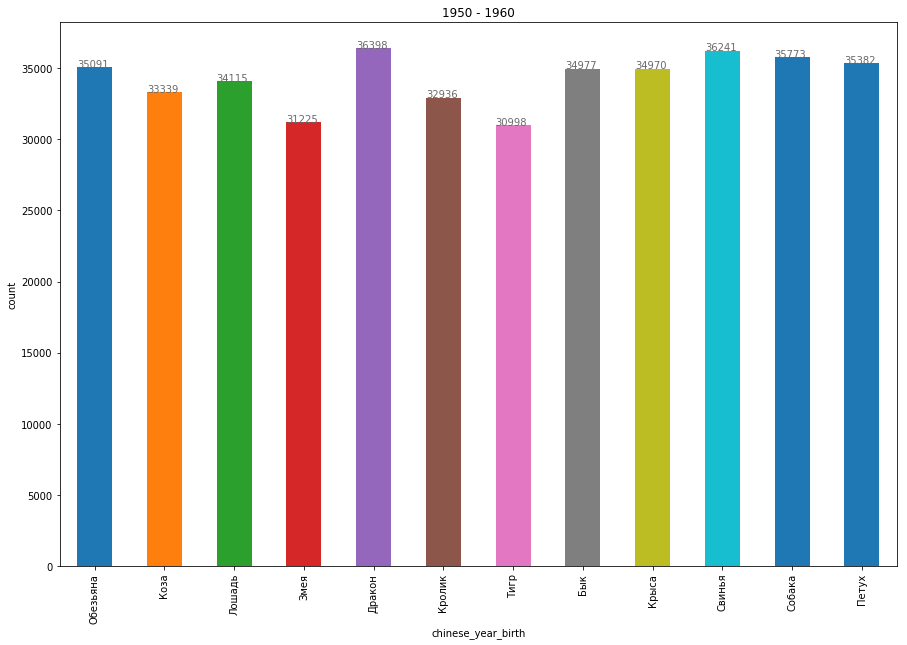

In [58]:
i=1950
build_graphic_date(i, i+10)

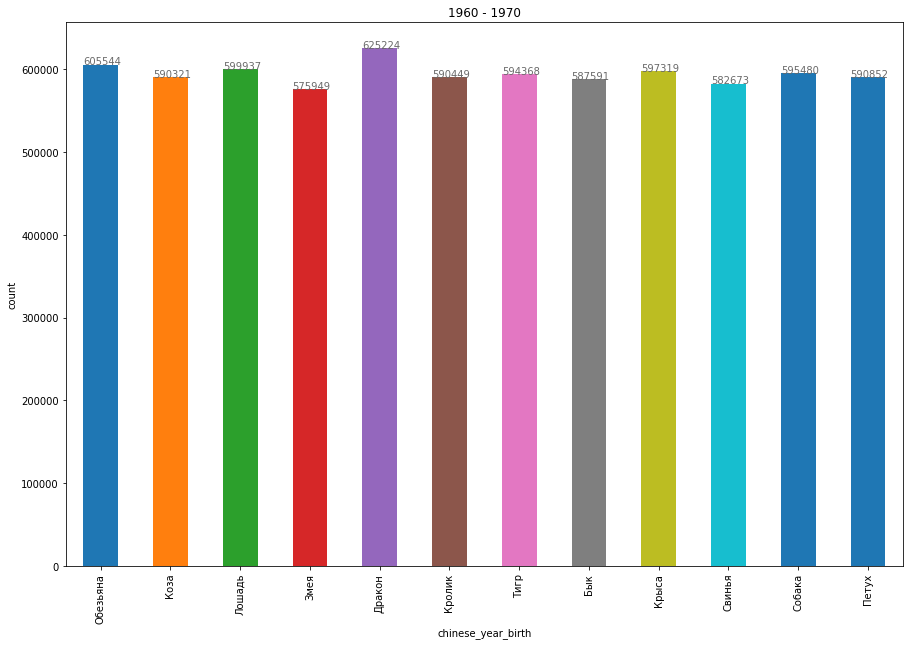

In [59]:
i=1960
build_graphic_date(i, i+10)

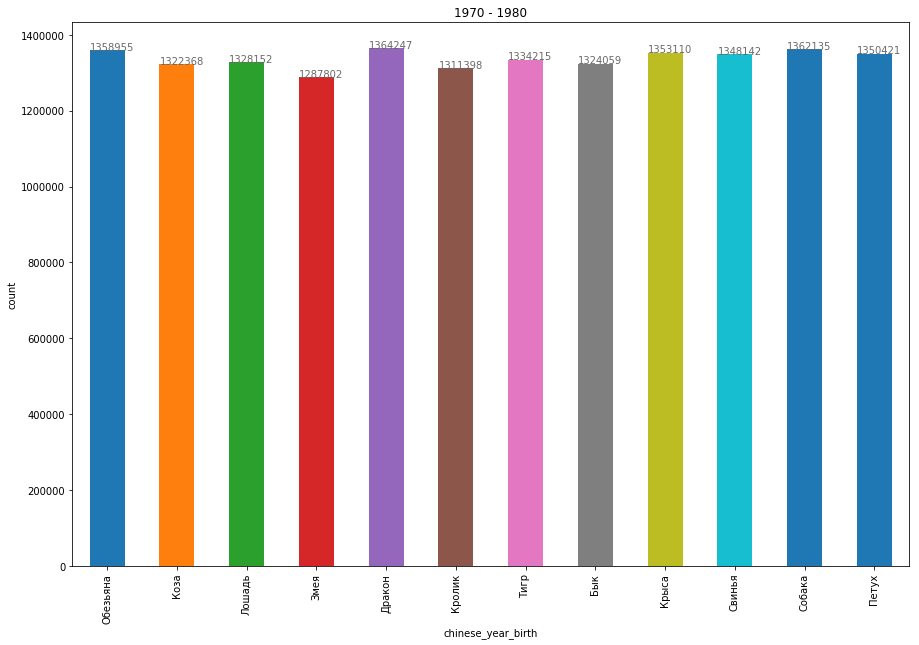

In [60]:
i=1970
build_graphic_date(i, i+10)

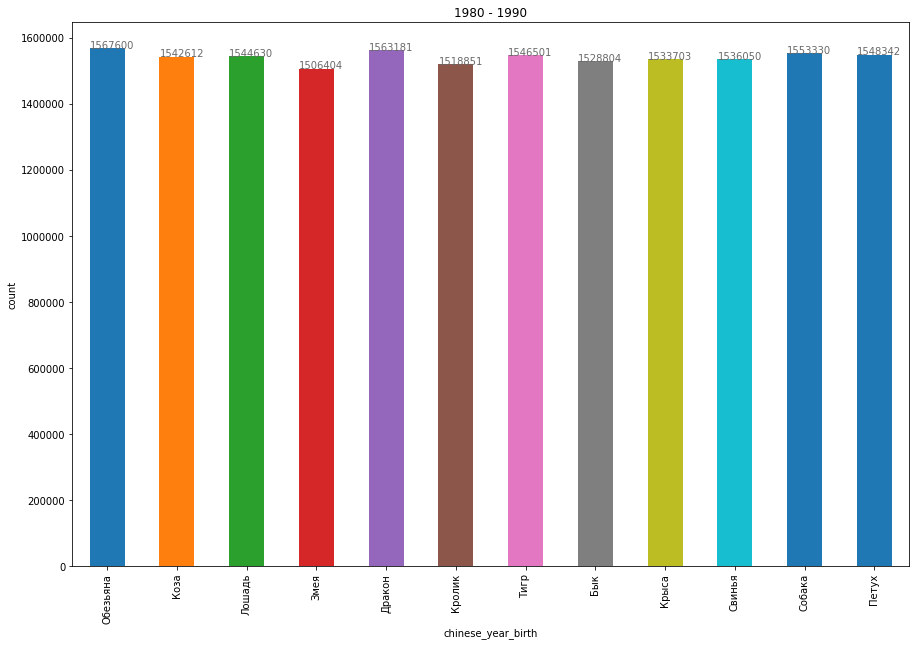

In [61]:
i=1980
build_graphic_date(i, i+10)

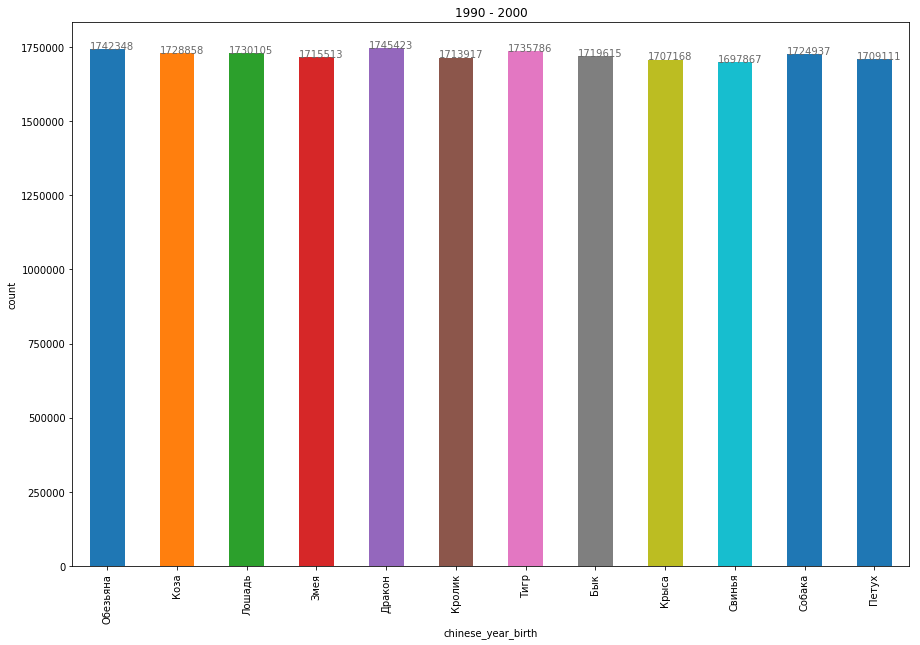

In [62]:
i=1990
build_graphic_date(i, i+10)

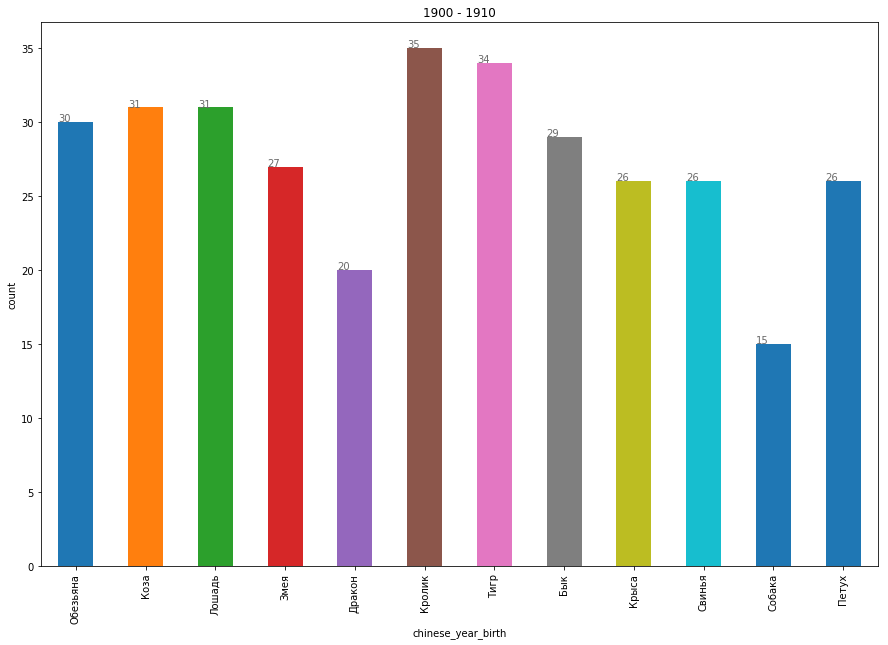

In [63]:
i=1900
build_graphic_date(i, i+10)

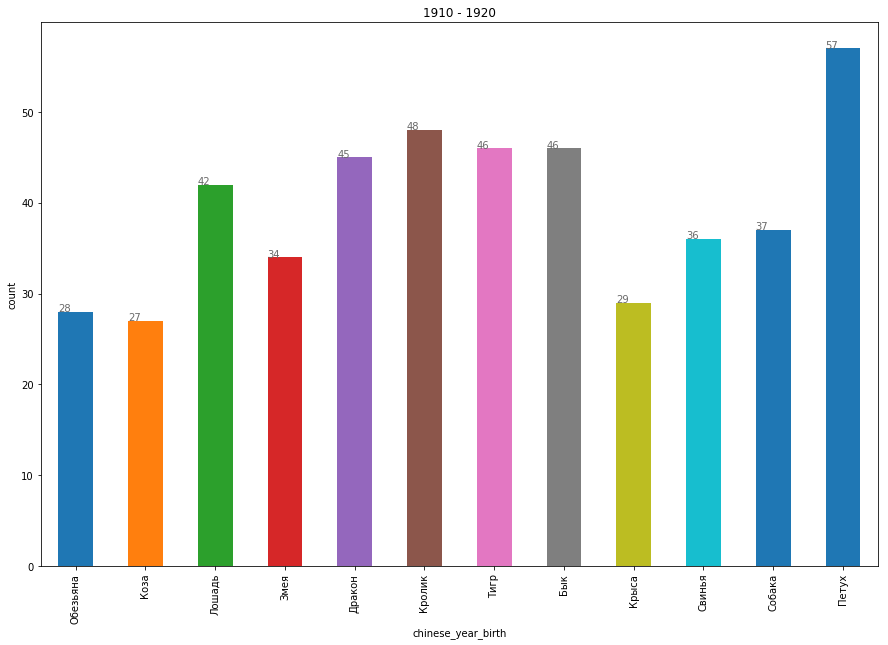

In [64]:
i=1910
build_graphic_date(i, i+10)

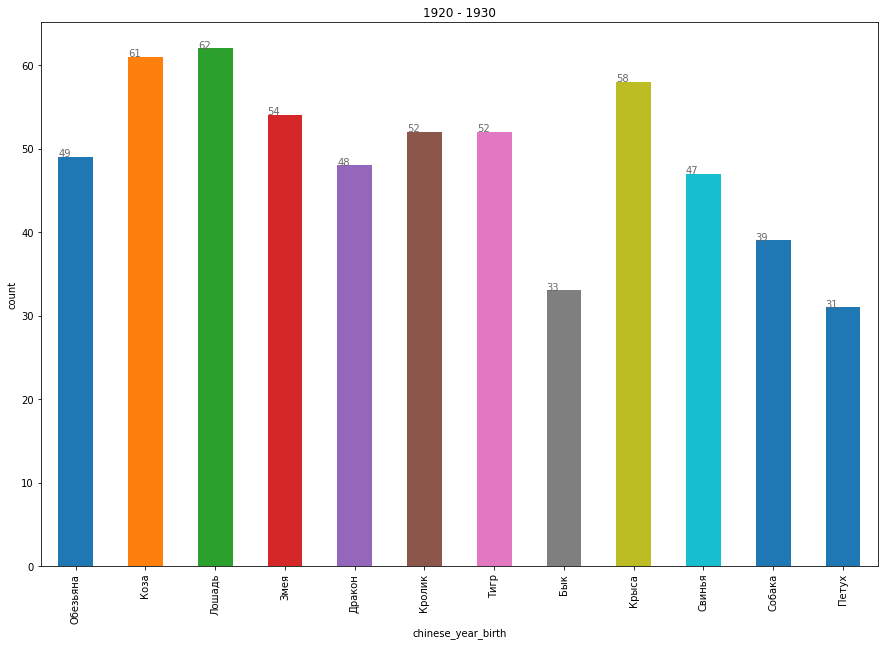

In [65]:
i=1920
build_graphic_date(i, i+10)

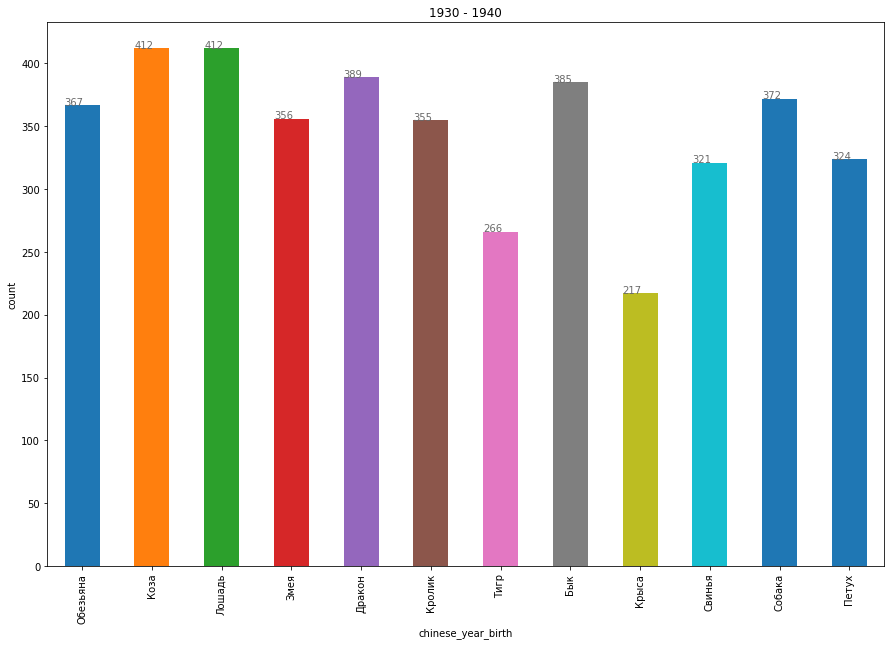

In [66]:
i=1930
build_graphic_date(i, i+10)

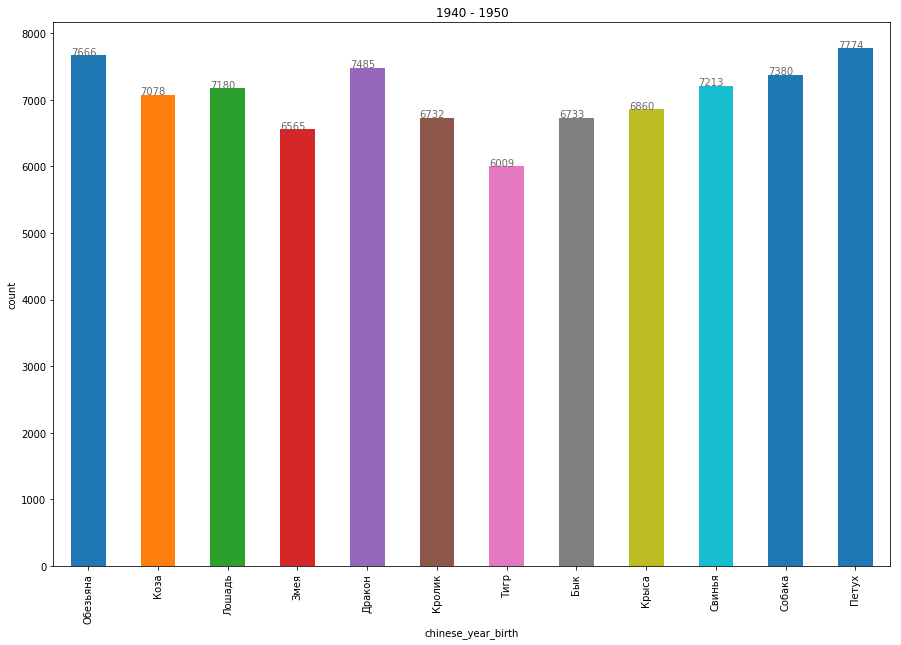

In [67]:
i=1940
build_graphic_date(i, i+10)